# Project 2: Object detection

### Part 1: Object localisation

In this part, we carry out object localisation. Note however, that we may share functions in both parts.

In [1]:
# Starting by importing useful libraries
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid, draw_bounding_boxes
from torchvision.ops import box_convert
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as FT
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# Make a seeding function for reproducibility
def seeder(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seeder()

In [3]:
# Import data
train_data = torch.load('./data/localization_train.pt')
val_data = torch.load('./data/localization_val.pt')
test_data = torch.load('./data/localization_test.pt')

In [4]:
# Make a training data loader (not yet normalised)
seeder()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)

Displaying some images to get an idea of the data:

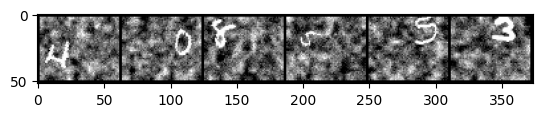

In [5]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.show()

images, _ = next(iter(train_loader))

img_grid_loc = make_grid(images[:6])
imshow(img_grid_loc)

Printing the shape of the images (will be important for the network architectures):

In [6]:
print(images.shape)

torch.Size([64, 1, 48, 60])


Let's check out the class distribution:

In [7]:
def get_class_distribution(data_loader):
    class_counts = Counter()

    for _, labels in data_loader:
        
        for label in labels:
            # Get label if object present
            if label[0] == 1:
                class_label = label[-1].item()
                class_counts.update([class_label])
            else:
                # If no object present
                class_counts.update([-1])

    return class_counts

class_distribution = get_class_distribution(train_loader)

for class_label, count in sorted(class_distribution.items()):
    if class_label < 0:
        print(f'Class {round(class_label)} (None): {count} instances')
    else:
        print(f'Class {round(class_label)}: {count} instances')

Class -1 (None): 5400 instances
Class 0: 5345 instances
Class 1: 6075 instances
Class 2: 5365 instances
Class 3: 5522 instances
Class 4: 5243 instances
Class 5: 4889 instances
Class 6: 5310 instances
Class 7: 5644 instances
Class 8: 5249 instances
Class 9: 5358 instances


Now, we wish to normalise the data with respect to the training data. We first get the mean and standard deviation of the training loader:

In [8]:
def get_mean_std(data_loader):
    mean = 0.0
    std = 0.0
    n_samples = 0

    # Sum over all batches
    for images, _ in data_loader:
        images = images.view(images.size(0), -1)
        
        n_samples += images.size(0)
        
        batch_mean = torch.mean(images, dim=1)
        batch_std = torch.std(images, dim=1)

        mean += batch_mean.sum().item()
        std += batch_std.sum().item()

    mean /= n_samples
    std /= n_samples

    return mean, std

mean, std = get_mean_std(train_loader)
print(f'Mean: {mean}, Std: {std}')

Mean: 0.4170836103002632, Std: 0.2124161434374273


Then, we normalise, and make dataloaders for all three sets:

In [9]:
def normalize_tensor_dataset(data_tensor, label_tensor, mean, std):    
    normalized_data_tensor = (data_tensor - mean) / std
    
    # Use TensorDataset wrapper to rejoin
    normalized_dataset = TensorDataset(normalized_data_tensor, label_tensor)
    
    return normalized_dataset

In [10]:
seeder()
train_norm = normalize_tensor_dataset(train_data.tensors[0], train_data.tensors[1], mean, std)
val_norm = normalize_tensor_dataset(val_data.tensors[0], val_data.tensors[1], mean, std)
test_norm = normalize_tensor_dataset(test_data.tensors[0], test_data.tensors[1], mean, std)

seeder()
train_loader_norm = DataLoader(train_norm, batch_size=64, shuffle=True, num_workers=4)
val_loader_norm = DataLoader(val_norm, batch_size=64, shuffle=False, num_workers=4)
test_loader_norm = DataLoader(test_norm, batch_size=64, shuffle=False, num_workers=4)

Now, we design the CNN architectures:

In [11]:
class LocCNN1(nn.Module):
    def __init__(self, num_classes=10):
        super(LocCNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2) # 48x60
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 24x30
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2) # 24x30, 12x15 after pooling
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 12 * 15, 120)
        self.fc2 = nn.Linear(120, 60)
        
        # Output layer (C + 5 outputs)
        self.fc3 = nn.Linear(60, num_classes + 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 32 * 12 * 15)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        return x

In [12]:
class LocCNN2(nn.Module):
    def __init__(self, num_classes=10):
        super(LocCNN2, self).__init__() # 48x60
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0) # 46x58
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0) # 44x56

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 22x28

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0) # 20x26, 10x13

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 10 * 13, 120)
        self.fc2 = nn.Linear(120, num_classes+5)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 10 * 13)
        
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return x

In [13]:
class LocCNN3(nn.Module):
    def __init__(self, num_classes=10):
        super(LocCNN3, self).__init__() # 48x60
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0) # 46x58
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=0) # 44x56, pool = 22x28
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=0) # 20x26
        self.conv4 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0) # 18x24, pool = 9x12
        self.conv5 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0) # 7x10

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 10, 100)
        self.fc2 = nn.Linear(100, num_classes+5)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        
        x = x.view(-1, 32 * 7 * 10)
        
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return x

In [14]:
class LocCNN4(nn.Module):
    def __init__(self, num_classes=10):
        super(LocCNN4, self).__init__() # 48x60
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=0) # 44x56, pool = 22x28
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0) # 20x26
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0) # 16x22
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0) # 14x20, pool = 7x10
        self.conv5 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=0) # 3x6

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 6, 80)
        self.fc2 = nn.Linear(80, num_classes+5)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        
        x = x.view(-1, 128 * 3 * 6)
        
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return x

In [15]:
# Custom loss function
def custom_loc_loss(outputs, labels):
    bce_logits_loss = nn.BCEWithLogitsLoss()
    mse_loss = nn.MSELoss(reduction='mean')
    ce_loss = nn.CrossEntropyLoss()
    
    # Split predictions and targets
    pred_pc = outputs[:, 0]
    pred_bbox = outputs[:, 1:5]
    pred_classes = outputs[:, 5:]
    
    label_pc = labels[:, 0]
    label_bbox = labels[:, 1:5]
    label_class = labels[:, 5].long()
    
    # Detection loss (binary cross-entropy for object presence)
    loss_A = bce_logits_loss(pred_pc, label_pc)
    
    # Mask for if and when there is an object or not (for each element in batch)
    mask = label_pc.squeeze() == 1
    valid_indices = mask.nonzero().squeeze(-1)
    
    # Localization loss (MSE for bounding box)
    loss_B = mse_loss(pred_bbox[valid_indices], label_bbox[valid_indices]) if valid_indices.numel() > 0 else 0
    
    # Classification loss (cross-entropy for class logits)
    loss_C = ce_loss(pred_classes[valid_indices], label_class[valid_indices]) if valid_indices.numel() > 0 else 0
    
    total_loss = loss_A + loss_B + loss_C
    return total_loss

In [16]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):

    training_losses = []
    validation_losses = []

    # Set to largest value
    best_val_loss = float('inf')

    # For early stopping
    patience_counter = 0
    patience = 1

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        # Compute training loss and update
        for i, (features, labels) in enumerate(train_loader):
            device = next(model.parameters()).device
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            loss = loss_fn(outputs, labels)

            # Zero gradients
            optimizer.zero_grad()
            # Backward pass and gradient descent
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        training_losses.append(avg_loss)

        # Compute validation loss
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for i, (features, labels) in enumerate(val_loader):
                device = next(model.parameters()).device
                features, labels = features.to(device), labels.to(device)

                # Forward pass
                outputs = model(features)
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)


        print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

            # Save best model state
            best_model = model.state_dict()
            patience_counter = 0 
        else:
            # Increment counter
            patience_counter += 1

        # Early stopping condition
        if patience_counter > patience:
            print(f"Stopping early at epoch {epoch+1} due to increasing validation loss.")
            break

    print('Training complete!')
    
    # Restore best model to the given model
    model.load_state_dict(best_model)
    return training_losses, validation_losses

Now, we perform the training for all models with the given optimisers:

In [17]:
seeder()
model1_1 = LocCNN1()
model1_2 = LocCNN2()
model1_3 = LocCNN3()
model1_4 = LocCNN4()


opt1_1 = torch.optim.Adam(model1_1.parameters(), lr=0.001)
opt1_2 = torch.optim.Adam(model1_2.parameters(), lr=0.001)
opt1_3 = torch.optim.Adam(model1_3.parameters(), lr=0.001)
opt1_4 = torch.optim.Adam(model1_4.parameters(), lr=0.001)

n_epochs = 15

tl1, vl1 = train(n_epochs, opt1_1, model1_1, custom_loc_loss, train_loader_norm, val_loader_norm)

Epoch 1/15, Training Loss: 2.0595, Validation Loss: 1.5701
Epoch 2/15, Training Loss: 1.2514, Validation Loss: 1.0442
Epoch 3/15, Training Loss: 0.8339, Validation Loss: 0.7974
Epoch 4/15, Training Loss: 0.6152, Validation Loss: 0.6712
Epoch 5/15, Training Loss: 0.4740, Validation Loss: 0.6310
Epoch 6/15, Training Loss: 0.3887, Validation Loss: 0.6236
Epoch 7/15, Training Loss: 0.3114, Validation Loss: 0.6265
Epoch 8/15, Training Loss: 0.2575, Validation Loss: 0.6594
Stopping early at epoch 8 due to increasing validation loss.
Training complete!


In [18]:
tl2, vl2 = train(n_epochs, opt1_2, model1_2, custom_loc_loss, train_loader_norm, val_loader_norm)

Epoch 1/15, Training Loss: 1.5915, Validation Loss: 0.8309
Epoch 2/15, Training Loss: 0.6050, Validation Loss: 0.5217
Epoch 3/15, Training Loss: 0.3563, Validation Loss: 0.4221
Epoch 4/15, Training Loss: 0.2235, Validation Loss: 0.4114
Epoch 5/15, Training Loss: 0.1413, Validation Loss: 0.4762
Epoch 6/15, Training Loss: 0.0949, Validation Loss: 0.5282
Stopping early at epoch 6 due to increasing validation loss.
Training complete!


In [19]:
tl3, vl3 = train(n_epochs, opt1_3, model1_3, custom_loc_loss, train_loader_norm, val_loader_norm)

Epoch 1/15, Training Loss: 1.9269, Validation Loss: 1.2347
Epoch 2/15, Training Loss: 0.9366, Validation Loss: 0.7937
Epoch 3/15, Training Loss: 0.6354, Validation Loss: 0.5850
Epoch 4/15, Training Loss: 0.4888, Validation Loss: 0.5147
Epoch 5/15, Training Loss: 0.3976, Validation Loss: 0.5497
Epoch 6/15, Training Loss: 0.3402, Validation Loss: 0.4194
Epoch 7/15, Training Loss: 0.3023, Validation Loss: 0.3825
Epoch 8/15, Training Loss: 0.2632, Validation Loss: 0.3666
Epoch 9/15, Training Loss: 0.2366, Validation Loss: 0.3427
Epoch 10/15, Training Loss: 0.2161, Validation Loss: 0.3386
Epoch 11/15, Training Loss: 0.1971, Validation Loss: 0.3729
Epoch 12/15, Training Loss: 0.1752, Validation Loss: 0.3565
Stopping early at epoch 12 due to increasing validation loss.
Training complete!


In [20]:
tl4, vl4 = train(n_epochs, opt1_4, model1_4, custom_loc_loss, train_loader_norm, val_loader_norm)

Epoch 1/15, Training Loss: 2.0606, Validation Loss: 1.3832
Epoch 2/15, Training Loss: 0.9746, Validation Loss: 0.6858
Epoch 3/15, Training Loss: 0.5763, Validation Loss: 0.5382
Epoch 4/15, Training Loss: 0.4280, Validation Loss: 0.4816
Epoch 5/15, Training Loss: 0.3452, Validation Loss: 0.3490
Epoch 6/15, Training Loss: 0.2823, Validation Loss: 0.3712
Epoch 7/15, Training Loss: 0.2409, Validation Loss: 0.3260
Epoch 8/15, Training Loss: 0.2118, Validation Loss: 0.3061
Epoch 9/15, Training Loss: 0.1821, Validation Loss: 0.3062
Epoch 10/15, Training Loss: 0.1596, Validation Loss: 0.3391
Stopping early at epoch 10 due to increasing validation loss.
Training complete!


Now, we compute the performance of the models (accuracy, IoU, and their mean):

In [21]:
def calculate_iou(pred_boxes, true_boxes):
    # Convert boxes
    pred_boxes_xyxy = box_convert(pred_boxes, in_fmt="cxcywh", out_fmt="xyxy")
    true_boxes_xyxy = box_convert(true_boxes, in_fmt="cxcywh", out_fmt="xyxy")

    # Calculate intersection
    xA = torch.max(pred_boxes_xyxy[:, 0], true_boxes_xyxy[:, 0])
    yA = torch.max(pred_boxes_xyxy[:, 1], true_boxes_xyxy[:, 1])
    xB = torch.min(pred_boxes_xyxy[:, 2], true_boxes_xyxy[:, 2])
    yB = torch.min(pred_boxes_xyxy[:, 3], true_boxes_xyxy[:, 3])

    intersection = torch.clamp(xB - xA, min=0) * torch.clamp(yB - yA, min=0)
    
    # Calculate areas of pred_boxes and true_boxes
    pred_area = (pred_boxes_xyxy[:, 2] - pred_boxes_xyxy[:, 0]) * (pred_boxes_xyxy[:, 3] - pred_boxes_xyxy[:, 1])
    true_area = (true_boxes_xyxy[:, 2] - true_boxes_xyxy[:, 0]) * (true_boxes_xyxy[:, 3] - true_boxes_xyxy[:, 1])
    
    union = pred_area + true_area - intersection

    iou = intersection / union
    
    return iou

def calculate_accuracy(pred_pc, pred_labels, true_pc, true_labels):

    # Correct detections
    correct_detections = ((torch.sigmoid(pred_pc) > 0.5) == (true_pc == 1)).float()
    
    # Correct classifications (only for correct detections)
    correct_classifications = (pred_labels == true_labels).float() * correct_detections
    
    accuracy = correct_classifications.sum() / correct_detections.sum()
    
    return accuracy


def evaluate_performance(pred_pc, pred_boxes, pred_labels, true_pc, true_boxes, true_labels):

    accuracy = calculate_accuracy(pred_pc, pred_labels, true_pc, true_labels)
    iou = calculate_iou(pred_boxes[true_pc == 1], true_boxes[true_pc == 1]).mean()
    
    # Combine accuracy and IoU for overall performance
    overall_performance = (accuracy + iou) / 2
    
    return overall_performance.item(), accuracy.item(), iou.item()

In [22]:
def evaluate_model(model, data_loader, detection=False):
    model.eval() 
    
    all_pred_pc = []
    all_pred_boxes = []
    all_pred_labels = []
    all_true_pc = []
    all_true_boxes = []
    all_true_labels = []
    
    with torch.no_grad():
        for i, (features, labels) in enumerate(data_loader):
            device = next(model.parameters()).device
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)

            if detection:
                # Iterate over each H_out and W_out
                for h in range(outputs.shape[1]): 
                    for w in range(outputs.shape[2]):

                        pred_pc, pred_boxes, pred_labels = outputs[:, h, w, 0], outputs[:, h, w, 1:5], outputs[:, h, w, 5:]
                        
                        true_pc, true_boxes, true_labels = labels[:, h, w, 0], labels[:, h, w, 1:5], labels[:, h, w, 5]

                        all_pred_pc.append(pred_pc.cpu())
                        all_pred_boxes.append(pred_boxes.cpu())
                        all_pred_labels.append(torch.argmax(pred_labels, dim=1).cpu())
                        all_true_pc.append(true_pc.cpu())
                        all_true_boxes.append(true_boxes.cpu())
                        all_true_labels.append(true_labels.cpu())
            else:           
                pred_pc, pred_boxes, pred_labels = outputs[:, 0], outputs[:, 1:5], outputs[:, 5:]
                
                true_pc, true_boxes, true_labels = labels[:, 0], labels[:, 1:5], labels[:, 5]

                all_pred_pc.append(pred_pc.cpu())
                all_pred_boxes.append(pred_boxes.cpu())
                all_pred_labels.append(torch.argmax(pred_labels, dim=1).cpu())
                all_true_pc.append(true_pc.cpu())
                all_true_boxes.append(true_boxes.cpu())
                all_true_labels.append(true_labels.cpu())
    
    all_pred_pc = torch.cat(all_pred_pc)
    all_pred_boxes = torch.cat(all_pred_boxes)
    all_pred_labels = torch.cat(all_pred_labels)
    all_true_pc = torch.cat(all_true_pc)
    all_true_boxes = torch.cat(all_true_boxes)
    all_true_labels = torch.cat(all_true_labels)

    
    overall_performance, accuracy, iou = evaluate_performance(
        all_pred_pc, all_pred_boxes, all_pred_labels,
        all_true_pc, all_true_boxes, all_true_labels
    )
    
    return overall_performance, accuracy, iou

We iterate over all models and pick out the best one (based on mean of accuracy and IoU):

In [23]:
# Store models in dictionary
models_dict = {
    'Model 1': model1_1,
    'Model 2': model1_2,
    'Model 3': model1_3,
    'Model 4': model1_4
}

models_losses = {
    'Model 1': [tl1, vl1],
    'Model 2': [tl2, vl2],
    'Model 3': [tl3, vl3],
    'Model 4': [tl4, vl4]
}

# Storing overall performance
val_performances = {}

for name, model in models_dict.items():
    val_performance, val_accuracy, val_iou = evaluate_model(model, val_loader_norm)
    val_performances[name] = val_performance
    print(f"Performance for {name} on Validation set: {val_performance:.4f}, Accuracy: {val_accuracy:.4f}, IoU: {val_iou:.4f}")

Performance for Model 1 on Validation set: 0.6175, Accuracy: 0.8013, IoU: 0.4337
Performance for Model 2 on Validation set: 0.6517, Accuracy: 0.8781, IoU: 0.4254
Performance for Model 3 on Validation set: 0.6927, Accuracy: 0.9091, IoU: 0.4763
Performance for Model 4 on Validation set: 0.6800, Accuracy: 0.9167, IoU: 0.4433


In [24]:
best_model_name = max(val_performances, key=val_performances.get)
best_model = models_dict[best_model_name]
print(f"Best Model: {best_model_name} with Validation performance: {val_performances[best_model_name]:.4f}")

Best Model: Model 3 with Validation performance: 0.6927


Now, we can plot the training and validation losses of the best model:

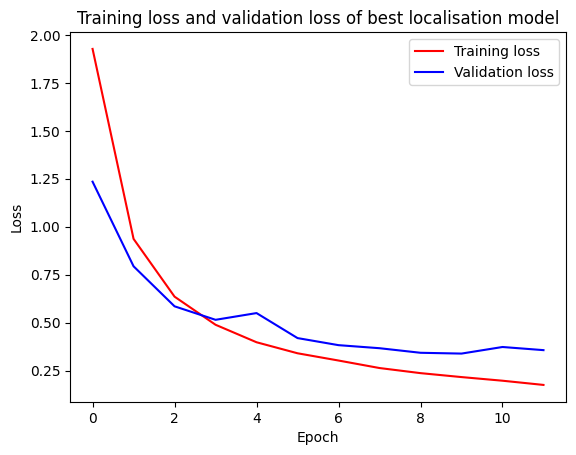

In [25]:
best_tl = (models_losses[best_model_name])[0]
best_vl = (models_losses[best_model_name])[1]

epochs_list = list(range(n_epochs+1))
plt.plot(best_tl, label='Training loss', color='r')
plt.plot(best_vl, label='Validation loss', color='b')

plt.title('Training loss and validation loss of best localisation model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We run the best model through test data:

In [26]:
test_performance, test_accuracy, test_iou = evaluate_model(best_model, test_loader_norm)
print(f"Performance for {best_model_name} on Test set: {test_performance:.4f}, Accuracy: {test_accuracy:.4f}, IoU: {test_iou:.4f}")

Performance for Model 3 on Test set: 0.6985, Accuracy: 0.9163, IoU: 0.4808


Now, we wish to plot some of the images and their bounding boxes:

In [27]:
# Denormalise images
def denormalise(image, mean, std):
    denormalised = image * std + mean
    return denormalised


def visualise_predictions(data_loader, model, num_images=5):
    model.eval()
    images_processed = 0

    with torch.no_grad():
        for images, labels in data_loader:
            device = next(model.parameters()).device
            images = images.to(device)
            labels = labels.to(device)
            
            # Generate model predictions
            outputs = model(images)
            
            img_height, img_width = images.shape[2], images.shape[3]
            
            for i in range(images.size(0)):
                if images_processed >= num_images:
                    return
                
                # Only use images with object
                if labels[i, 0] <= 0:
                    continue

                img_denorm = denormalise(images[i], mean, std)

                # Extract and scale predicted and true boxes from normalized coordinates to pixel coordinates
                pred_box = outputs[i, 1:5]
                true_box = labels[i, 1:5]

                # Convert boxes and scale to pixel dimensions
                pred_box_scaled = box_convert(pred_box.unsqueeze(0), in_fmt='cxcywh', out_fmt='xyxy') * torch.tensor([img_width, img_height, img_width, img_height], device=device)
                true_box_scaled = box_convert(true_box.unsqueeze(0), in_fmt='cxcywh', out_fmt='xyxy') * torch.tensor([img_width, img_height, img_width, img_height], dtype=torch.float32, device=device)

                # Draw bounding boxes
                image_with_box1 = draw_bounding_boxes(FT.convert_image_dtype(img_denorm.cpu(), dtype=torch.uint8), pred_box_scaled, colors=['red'], width=1)
                image_with_box2 = draw_bounding_boxes(image_with_box1, true_box_scaled, colors=["green"], width=1)

                plt.figure(figsize=(6, 6))
                # PIL is well optimised for torch functions
                plt.imshow(FT.to_pil_image(image_with_box2))
                
                # Display actual and predicted class
                true_label = labels[i, 5].item()
                pred_label = outputs[i, 5:].argmax().item()
                plt.title(f"True (Green): {round(true_label)}, Predicted (Red): {pred_label}")
                plt.axis('off')
                plt.show()

                images_processed += 1

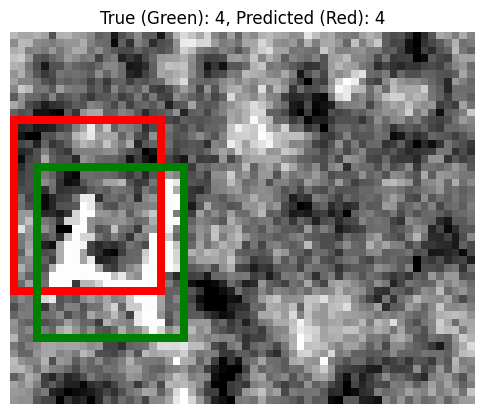

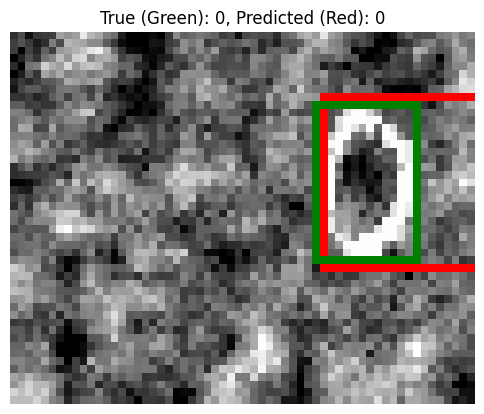

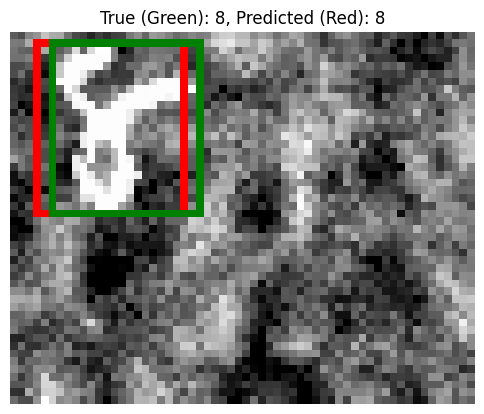

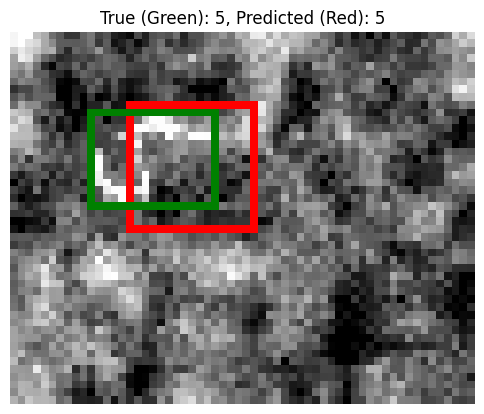

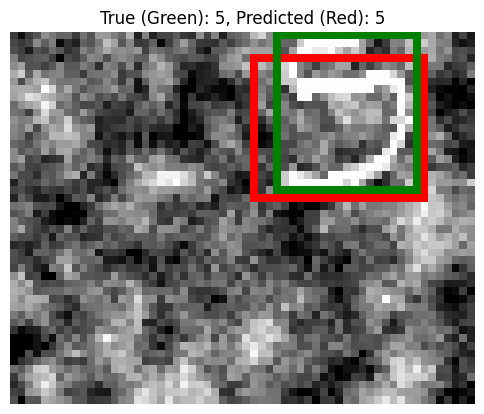

In [28]:
seeder()
visualise_predictions(train_loader_norm, best_model)

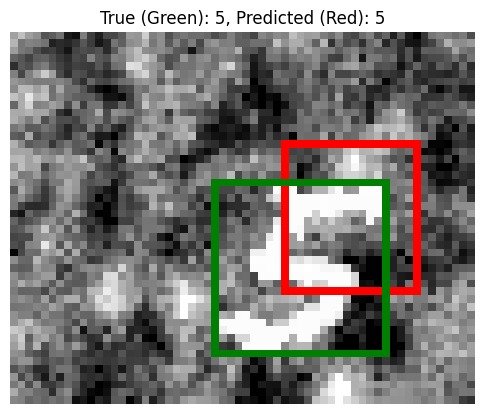

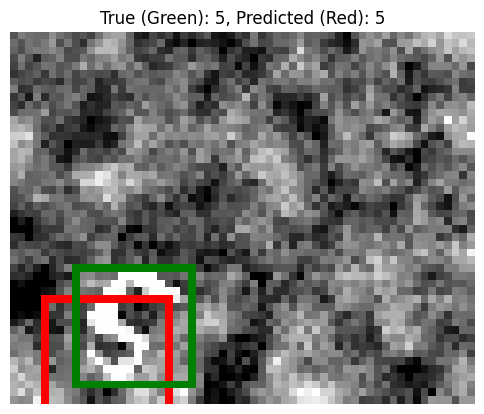

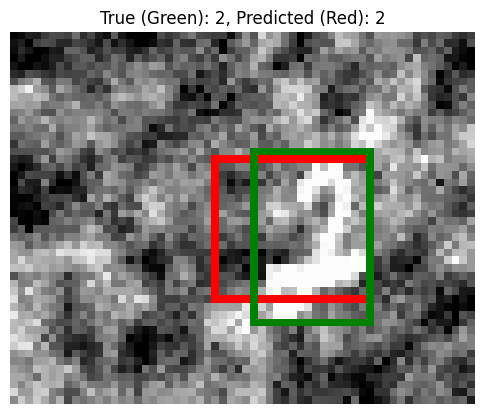

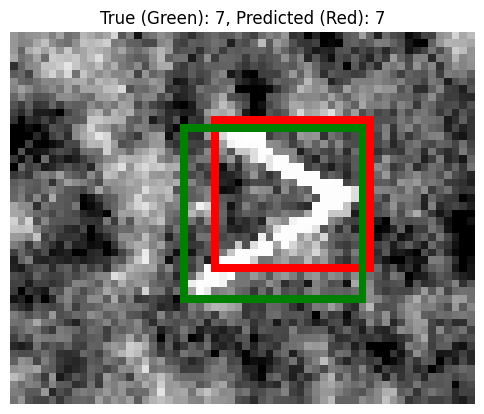

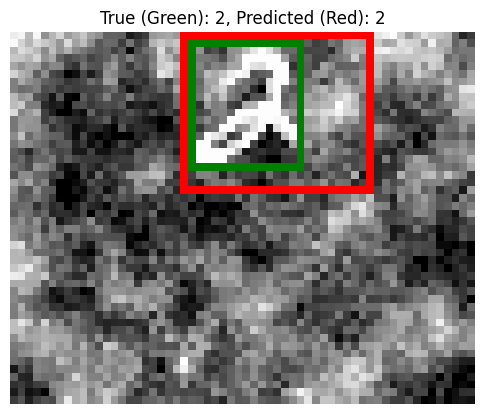

In [29]:
seeder()
visualise_predictions(val_loader_norm, best_model)

### Part 2: Object detection

We start by importing the data, as usual:

In [30]:
# Not yet optimised for a H_out, W_out grid
list_y_true_train = torch.load('./data/list_y_true_train.pt')
list_y_true_val = torch.load('./data/list_y_true_val.pt')
list_y_true_test = torch.load('./data/list_y_true_test.pt')

In [31]:
# Already optimised for a H_out, W_out grid
det_x_train = (torch.load('./data/detection_train.pt')).tensors[0]
det_x_val = (torch.load('./data/detection_val.pt')).tensors[0]
det_x_test = (torch.load('./data/detection_test.pt')).tensors[0]

In [32]:
H_out, W_out = 2, 3

def convert_to_grid_format(dataset, H_out, W_out):
    N_tot = len(dataset)
    converted_dataset = torch.zeros((N_tot, H_out, W_out, 6))

    for i, image_objects in enumerate(dataset):
        for obj in image_objects:
            # Calculate which cell the object's center (x, y) falls into
            cell_x = int(obj[1] * W_out)
            cell_y = int(obj[2] * H_out)

            # Correct for boundary cases
            cell_x = min(cell_x, W_out - 1)
            cell_y = min(cell_y, H_out - 1)
            
            # Convert to local cell coordinates
            local_x = (obj[1] * W_out) - cell_x
            local_y = (obj[2] * H_out) - cell_y

            # H and W can span multiple cells
            local_w = obj[3] * W_out
            local_h = obj[4] * H_out
            
            # Update the tensor with information in local coordinates
            converted_dataset[i, cell_y, cell_x] = torch.tensor([obj[0], local_x, local_y, local_w, local_h, obj[5]])
    
    return converted_dataset

In [33]:
ly_train_converted = convert_to_grid_format(list_y_true_train, H_out, W_out)
ly_val_converted = convert_to_grid_format(list_y_true_val, H_out, W_out)
ly_test_converted = convert_to_grid_format(list_y_true_test, H_out, W_out)

In [34]:
# Quick display of result
ly_train_converted

tensor([[[[1.0000, 0.7750, 0.8125, 0.3500, 0.7917, 1.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.9500, 0.3333, 0.7000, 0.6667, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.5000, 0.3542, 0.5000, 0.9583, 1.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000,

We then normalise, merge, and then make dataloaders:

In [35]:
seeder()
det_train_temp = TensorDataset(det_x_train, ly_train_converted)

seeder()
train_loader_det = DataLoader(det_train_temp, batch_size=64, shuffle=True, num_workers=4)

In [36]:
mean_det, std_det = get_mean_std(train_loader_det)

seeder()
train_norm_det = normalize_tensor_dataset(det_x_train, ly_train_converted, mean_det, std_det)
val_norm_det = normalize_tensor_dataset(det_x_val, ly_val_converted, mean_det, std_det)
test_norm_det = normalize_tensor_dataset(det_x_test, ly_test_converted, mean_det, std_det)

seeder()
train_loader_det_norm = DataLoader(train_norm_det, batch_size=64, shuffle=True, num_workers=4)
val_loader_det_norm = DataLoader(val_norm_det, batch_size=64, shuffle=True, num_workers=4)
test_loader_det_norm = DataLoader(test_norm_det, batch_size=64, shuffle=True, num_workers=4)

Displaying some images again:

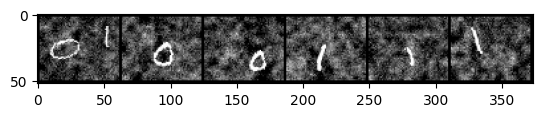

In [37]:
images_det, _ = next(iter(train_loader_det))

img_grid_det = make_grid(images_det[:6])
imshow(img_grid_det)

Dimensions of images (same as localisation in this case):

In [38]:
print(images_det.shape)

torch.Size([64, 1, 48, 60])


Computing class distribution, but for each grid cell:

In [39]:
def get_class_distribution_det(data_loader):
    class_counts = Counter()

    for _, labels in data_loader:
        
        for label in labels:

            for l in label:
                if l[0, 0] == 1:
                    class_label = l[0, -1].item()
                    class_counts.update([class_label])
                else:
                    class_counts.update([-1])

    return class_counts

class_distribution_det = get_class_distribution_det(train_loader_det_norm)

for class_id, count in sorted(class_distribution_det.items()):
    if class_id < 0:
        print(f'Class {round(class_id)} (None): {count} instances')
    else:
        print(f'Class {round(class_id)}: {count} instances')

Class -1 (None): 45296 instances
Class 0: 3971 instances
Class 1: 4481 instances


Designing CNN architectures:

In [40]:
class DetCNN1(nn.Module):
    def __init__(self, num_classes=2):
        super(DetCNN1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # 48x60
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 24x30
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 24x30
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 12x15

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 12x15
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3), # 4x5
            
            nn.Conv2d(64, 128, kernel_size=(2, 3), stride=1, padding=0), # 3x3
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=(2, 1), stride=1, padding=0), # 2x3
            nn.ReLU(inplace=True),
        )
        
        # Final layer to get the desired output depth (C + 5)
        self.detector = nn.Conv2d(256, num_classes + 5, kernel_size=1)  # 7x2x3
        
    def forward(self, x):
        x = self.features(x)
        x = self.detector(x)
        # Adjust the output to match the expected format (N, H_out, W_out, C + 5)
        return x.permute(0, 2, 3, 1)

In [41]:
class DetCNN2(nn.Module):
    def __init__(self, num_classes=2):
        super(DetCNN2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), # 48x60
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 24x30
            
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), # 24x30
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 12x15

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2), # 12x15
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3), # 4x5
            
            nn.Conv2d(128, 64, kernel_size=(2, 3), stride=1, padding=0), # 3x3
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 32, kernel_size=(2, 1), stride=1, padding=0), # 2x3
            nn.ReLU(inplace=True),
        )
        
        # Final layer to get the desired output depth (C + 5)
        self.detector = nn.Conv2d(32, num_classes + 5, kernel_size=1)  # 7x2x3
        
    def forward(self, x):
        x = self.features(x)
        x = self.detector(x)
        # Adjust the output to match the expected format (N, H_out, W_out, C + 5)
        return x.permute(0, 2, 3, 1)

In [42]:
class DetCNN3(nn.Module):
    def __init__(self, num_classes=2):
        super(DetCNN3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=0), # 44x56
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 22x28
            
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=0), # 18x24
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 9x12

            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=0), # 5x8
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 32, kernel_size=(3, 5), stride=1, padding=0), # 3x4
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=(2, 2), stride=1, padding=0), # 2x3
            nn.ReLU(inplace=True),
        )
        
        # Final layer to get the desired output depth (C + 5)
        self.detector = nn.Conv2d(64, num_classes + 5, kernel_size=1)  # 7x2x3
        
    def forward(self, x):
        x = self.features(x)
        x = self.detector(x)
        # Adjust the output to match the expected format (N, H_out, W_out, C + 5)
        return x.permute(0, 2, 3, 1)

In [43]:
class DetCNN4(nn.Module):
    def __init__(self, num_classes=2):
        super(DetCNN4, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=5, stride=1, padding=0), # 44x56
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 22x28
            
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0), # 20x26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 10x13

            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=0), # 6x9
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 16, kernel_size=(3, 5), stride=1, padding=0), # 4x5
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 8, kernel_size=(3, 3), stride=1, padding=0), # 2x3
            nn.ReLU(inplace=True),
        )
        
        # Final layer to get the desired output depth (C + 5)
        self.detector = nn.Conv2d(8, num_classes + 5, kernel_size=1)  # 7x2x3
        
    def forward(self, x):
        x = self.features(x)
        x = self.detector(x)
        # Adjust the output to match the expected format (N, H_out, W_out, C + 5)
        return x.permute(0, 2, 3, 1)

In [44]:
def custom_det_loss(predictions, targets, loss_fn=custom_loc_loss):

    total_loss = 0.0
    for h in range(predictions.shape[1]):  # Iterate over grid height (2)
        for w in range(predictions.shape[2]):  # Iterate over grid width (3)

            pred_current = predictions[:, h, w, :] 
            target_current = targets[:, h, w, :]
            
            cell_loss = loss_fn(pred_current, target_current)
            total_loss += cell_loss
    
    return total_loss

Training the model instances:

In [45]:
seeder()
model2_1 = DetCNN1()
model2_2 = DetCNN2()
model2_3 = DetCNN3()
model2_4 = DetCNN4()

n_epochs = 15

loss_fn = custom_det_loss

opt2_1 = torch.optim.Adam(model2_1.parameters(), lr=0.001)
opt2_2 = torch.optim.Adam(model2_2.parameters(), lr=0.001)
opt2_3 = torch.optim.Adam(model2_3.parameters(), lr=0.001)
opt2_4 = torch.optim.Adam(model2_4.parameters(), lr=0.001)


tld1, vld1 = train(n_epochs, opt2_1, model2_1, loss_fn, train_loader_det_norm, val_loader_det_norm)

Epoch 1/15, Training Loss: 2.7194, Validation Loss: 0.7813
Epoch 2/15, Training Loss: 0.7354, Validation Loss: 0.5271
Epoch 3/15, Training Loss: 0.5150, Validation Loss: 0.4891
Epoch 4/15, Training Loss: 0.4197, Validation Loss: 0.5927
Epoch 5/15, Training Loss: 0.3551, Validation Loss: 0.4339
Epoch 6/15, Training Loss: 0.3333, Validation Loss: 0.4391
Epoch 7/15, Training Loss: 0.3007, Validation Loss: 0.3752
Epoch 8/15, Training Loss: 0.2674, Validation Loss: 0.3651
Epoch 9/15, Training Loss: 0.2457, Validation Loss: 0.4146
Epoch 10/15, Training Loss: 0.2364, Validation Loss: 0.3691
Stopping early at epoch 10 due to increasing validation loss.
Training complete!


In [46]:
tld2, vld2 = train(n_epochs, opt2_2, model2_2, loss_fn, train_loader_det_norm, val_loader_det_norm)

Epoch 1/15, Training Loss: 2.6751, Validation Loss: 0.8408
Epoch 2/15, Training Loss: 0.5668, Validation Loss: 0.5226
Epoch 3/15, Training Loss: 0.4086, Validation Loss: 0.4791
Epoch 4/15, Training Loss: 0.3611, Validation Loss: 0.4464
Epoch 5/15, Training Loss: 0.3225, Validation Loss: 0.4144
Epoch 6/15, Training Loss: 0.2860, Validation Loss: 0.3885
Epoch 7/15, Training Loss: 0.2453, Validation Loss: 0.3789
Epoch 8/15, Training Loss: 0.2361, Validation Loss: 0.4547
Epoch 9/15, Training Loss: 0.1967, Validation Loss: 0.4050
Stopping early at epoch 9 due to increasing validation loss.
Training complete!


In [47]:
tld3, vld3 = train(n_epochs, opt2_3, model2_3, loss_fn, train_loader_det_norm, val_loader_det_norm)

Epoch 1/15, Training Loss: 5.8189, Validation Loss: 4.3359
Epoch 2/15, Training Loss: 4.2074, Validation Loss: 4.0136
Epoch 3/15, Training Loss: 3.8623, Validation Loss: 3.7567
Epoch 4/15, Training Loss: 3.7451, Validation Loss: 3.7591
Epoch 5/15, Training Loss: 3.6777, Validation Loss: 3.7334
Epoch 6/15, Training Loss: 3.6120, Validation Loss: 3.6756
Epoch 7/15, Training Loss: 3.5826, Validation Loss: 3.6978
Epoch 8/15, Training Loss: 3.5491, Validation Loss: 3.6408
Epoch 9/15, Training Loss: 3.4943, Validation Loss: 3.7395
Epoch 10/15, Training Loss: 3.4674, Validation Loss: 3.5763
Epoch 11/15, Training Loss: 3.3736, Validation Loss: 3.5219
Epoch 12/15, Training Loss: 3.2856, Validation Loss: 3.5866
Epoch 13/15, Training Loss: 3.1458, Validation Loss: 3.4890
Epoch 14/15, Training Loss: 3.0513, Validation Loss: 3.2591
Epoch 15/15, Training Loss: 2.8149, Validation Loss: 3.1258
Training complete!


In [48]:
tld4, vld4 = train(n_epochs, opt2_4, model2_4, loss_fn, train_loader_det_norm, val_loader_det_norm)

Epoch 1/15, Training Loss: 7.1586, Validation Loss: 4.6623
Epoch 2/15, Training Loss: 4.4616, Validation Loss: 4.3084
Epoch 3/15, Training Loss: 4.1962, Validation Loss: 4.1140
Epoch 4/15, Training Loss: 3.9668, Validation Loss: 3.9284
Epoch 5/15, Training Loss: 3.8533, Validation Loss: 3.8949
Epoch 6/15, Training Loss: 3.7999, Validation Loss: 3.8388
Epoch 7/15, Training Loss: 3.7583, Validation Loss: 3.8421
Epoch 8/15, Training Loss: 3.7034, Validation Loss: 3.8557
Stopping early at epoch 8 due to increasing validation loss.
Training complete!


Evaluating performance of model by iterating over the cells:

Compute performance of each model and pick out the best:

In [49]:
models_dict_det = {
    'Model 1': model2_1,
    'Model 2': model2_2,
    'Model 3': model2_3,
    'Model 4': model2_4
}

models_losses = {
    'Model 1': [tld1, vld1],
    'Model 2': [tld2, vld2],
    'Model 3': [tld3, vld3],
    'Model 4': [tld4, vld4]
}

# Storing overall performance
val_performances_det = {}

for name, model in models_dict_det.items():
    val_performance, val_accuracy, val_iou = evaluate_model(model, val_loader_det_norm, True)
    val_performances_det[name] = val_performance
    print(f"Performance for {name} on Validation set: {val_performance:.4f}, Accuracy: {val_accuracy:.4f}, IoU: {val_iou:.4f}")

Performance for Model 1 on Validation set: 0.5355, Accuracy: 0.3387, IoU: 0.7323
Performance for Model 2 on Validation set: 0.5298, Accuracy: 0.3506, IoU: 0.7090
Performance for Model 3 on Validation set: 0.4281, Accuracy: 0.5194, IoU: 0.3369
Performance for Model 4 on Validation set: 0.3746, Accuracy: 0.5072, IoU: 0.2421


In [50]:
best_model_name_det = max(val_performances_det, key=val_performances_det.get)
best_model_det = models_dict_det[best_model_name_det]
print(f"Best Model: {best_model_name_det} with Validation performance: {val_performances_det[best_model_name_det]:.4f}")

Best Model: Model 1 with Validation performance: 0.5355


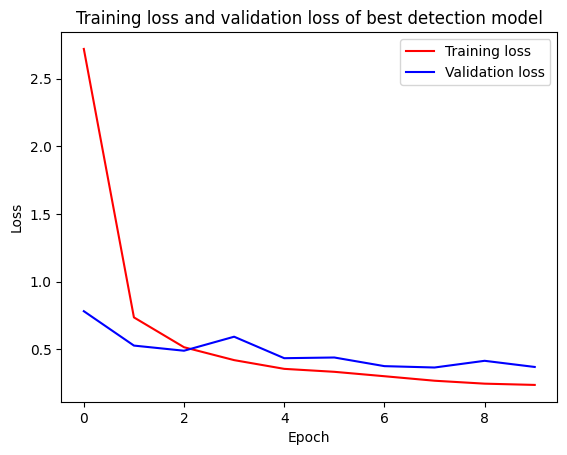

In [51]:
best_tl_det = (models_losses[best_model_name_det])[0]
best_vl_det = (models_losses[best_model_name_det])[1]

plt.plot(best_tl_det, label='Training loss', color='r')
plt.plot(best_vl_det, label='Validation loss', color='b')

plt.title('Training loss and validation loss of best detection model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
test_performance_det, test_accuracy_det, test_iou_det = evaluate_model(best_model_det, test_loader_det_norm, True)
print(f"Performance for {best_model_name_det} on Test set: {test_performance_det:.4f}, Accuracy: {test_accuracy_det:.4f}, IoU: {test_iou_det:.4f}")

Performance for Model 1 on Test set: 0.5334, Accuracy: 0.3346, IoU: 0.7322


Display images:

In [53]:
def box_convert_detection(box, cell_index_x, cell_index_y, H_out, W_out, img_width, img_height):

    cell_width = img_width / W_out
    cell_height = img_height / H_out

    # Calculate the absolute position of the cell's top-left corner
    cell_top_left_x = cell_index_x * cell_width
    cell_top_left_y = cell_index_y * cell_height

    # Convert box coordinates from normalized to absolute pixel values
    box_abs = torch.tensor([
        (box[0] * cell_width) + cell_top_left_x,
        (box[1] * cell_height) + cell_top_left_y,
        box[2] * cell_width,
        box[3] * cell_height
    ])

    # Convert from center-width-height (cxcywh) to corner coordinates (xyxy) for display
    box_abs_xyxy = box_convert(box_abs.unsqueeze(0), in_fmt='cxcywh', out_fmt='xyxy').squeeze(0)

    return box_abs_xyxy

def visualise_predictions_det(data_loader, model, num_images=5):
    model.eval()
    images_processed = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            device = next(model.parameters()).device
            images = images.to(device)
            labels = labels.to(device)
            
            # Generate model predictions
            outputs = model(images)
            
            img_height, img_width = images.shape[2], images.shape[3]
            H_out, W_out = outputs.shape[1], outputs.shape[2]
            
            for i in range(images.size(0)):
                if images_processed >= num_images:
                    return

                img = images[i]
                if img.shape[0] == 1:
                    # Repeat channels to make RGB for greyscale
                    img = img.repeat(3, 1, 1)

                img_denorm = denormalise(img, mean_det, std_det)

                for h in range(H_out):
                    for w in range(W_out):
                        pc = outputs[i, h, w, 0].item()

                        # Ignore grid cells with no objects
                        if pc <= 0:
                            continue

                        pred_box = outputs[i, h, w, 1:5]
                        true_box = labels[i, h, w, 1:5]

                        true_label = labels[i, h, w, 5].item()
                        pred_label = outputs[i, h, w, 5:].argmax().item()

                        if labels[i, h, w, 0] > 0.5:
                            print(f'Predicted: {pred_label}')
                            print(f'True: {round(true_label)}')


                        # Convert and scale boxes
                        pred_box_scaled = box_convert_detection(pred_box, w, h, H_out, W_out, img_width, img_height)
                        true_box_scaled = box_convert_detection(true_box, w, h, H_out, W_out, img_width, img_height)
                        
                        # Draw bounding boxes
                        img_denorm = FT.convert_image_dtype(img_denorm, dtype=torch.uint8)

                        img_denorm = draw_bounding_boxes(img_denorm, pred_box_scaled.unsqueeze(0).to(torch.int), colors='red', width=1)

                        if not torch.all(true_box == 0):
                            img_denorm = draw_bounding_boxes(img_denorm, true_box_scaled.unsqueeze(0).to(torch.int), colors='green', width=1)
                
                # Convert tensor image to PIL for display
                plt.figure(figsize=(6, 6))
                plt.imshow(FT.to_pil_image(img_denorm.cpu()))
                plt.axis('off')
                plt.title('Predicted = Red, True = Green')
                plt.show()

                images_processed += 1

Predicted: 0
True: 0
Predicted: 1
True: 1


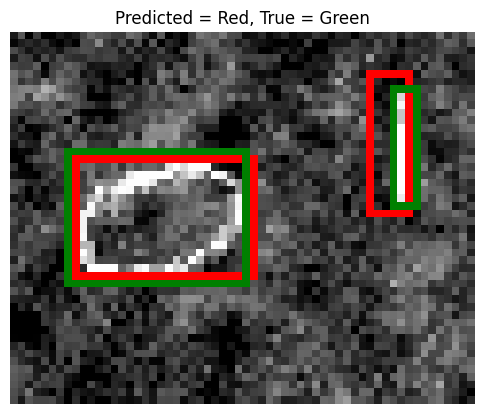

Predicted: 0
True: 0


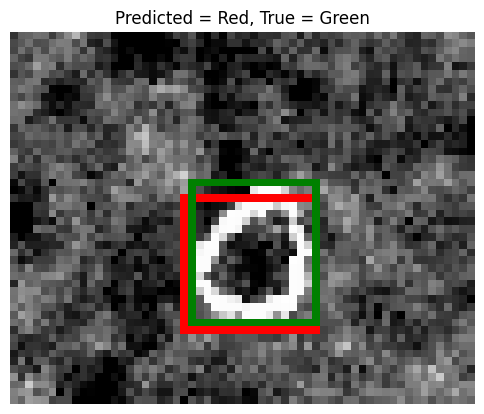

Predicted: 0
True: 0


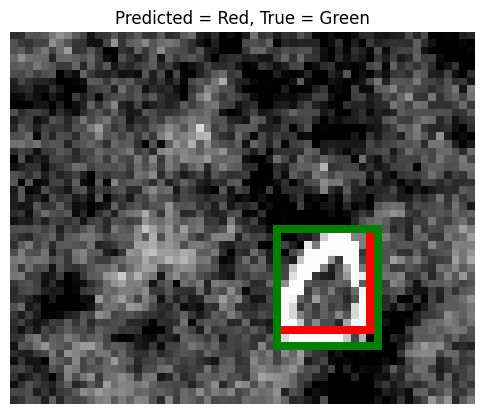

Predicted: 1
True: 1


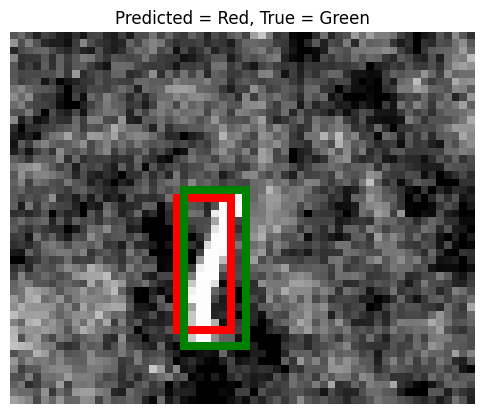

Predicted: 1
True: 1


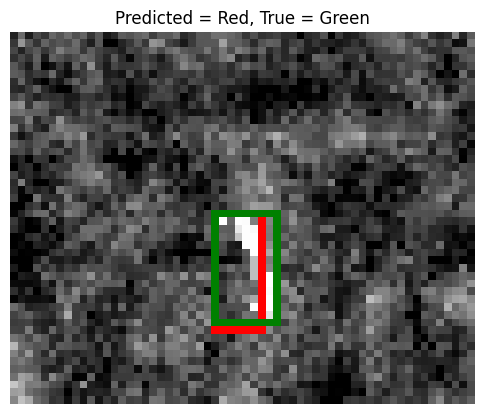

In [54]:
seeder()
visualise_predictions_det(train_loader_det_norm, best_model_det)

Predicted: 0
True: 0


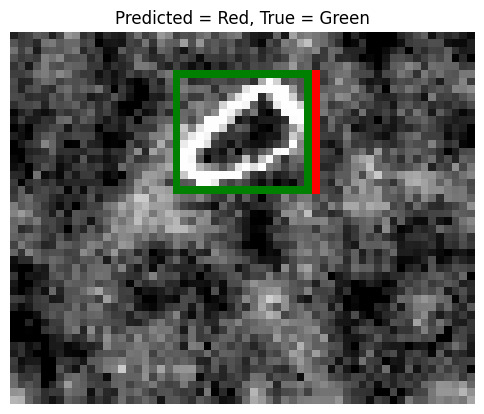

Predicted: 1
True: 1
Predicted: 0
True: 0


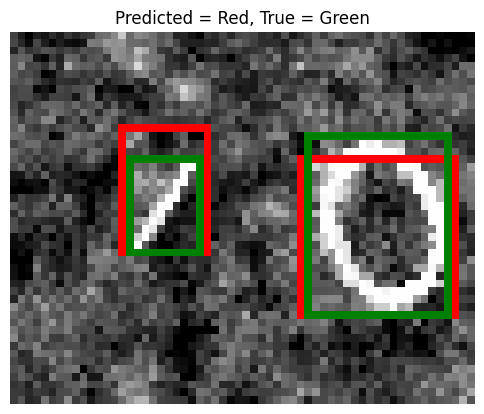

Predicted: 0
True: 0


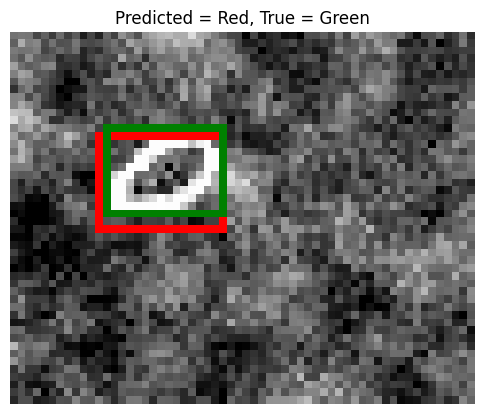

Predicted: 1
True: 1


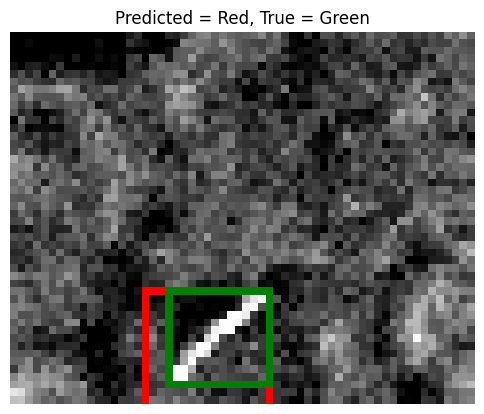

Predicted: 1
True: 1


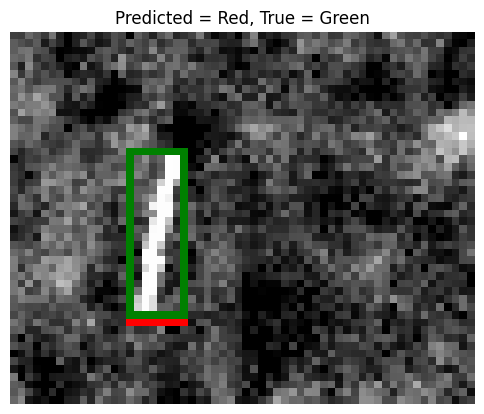

: 

In [55]:
seeder(7)
visualise_predictions_det(val_loader_det_norm, best_model_det)